<a href="https://colab.research.google.com/github/Dharamchandpatle/Refinery-AIML/blob/main/IOCL_AnamolyDetectionAutomation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IOCL Anamoly Detection Automation

In [6]:
# INSTALL & IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import smtplib
from email.message import EmailMessage



In [ ]:
# UPLOAD DATASET
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)


In [8]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Handle missing values (robust)
df.fillna(df.median(numeric_only=True), inplace=True)

# Remove physically impossible values
df = df[
    (df["electricity_kwh"] > 0) &
    (df["steam_usage"] > 0) &
    (df["fuel_usage"] > 0) &
    (df["production_tons"] > 0)
]

# Clip noisy sensor spikes
df["electricity_kwh"] = df["electricity_kwh"].clip(400, 1600)
df["steam_usage"] = df["steam_usage"].clip(200, 900)
df["fuel_usage"] = df["fuel_usage"].clip(100, 700)



In [9]:
# FEATURE ENGINEERING (SEC)
df["SEC"] = (
    df["electricity_kwh"] +
    df["steam_usage"] +
    df["fuel_usage"]
) / df["production_tons"]


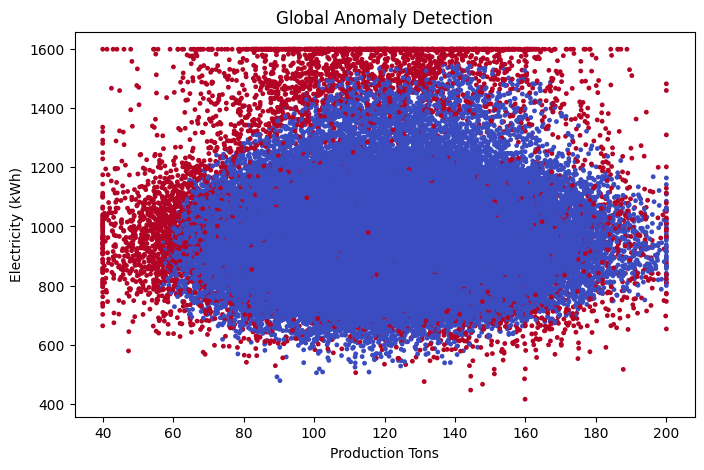

In [10]:
# GLOBAL ANOMALY DETECTION
features = [
    "electricity_kwh",
    "steam_usage",
    "fuel_usage",
    "production_tons",
    "SEC"
]

X = df[features]

global_model = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)

df["anomaly"] = np.where(global_model.fit_predict(X) == -1, 1, 0)


# GLOBAL ANOMALIES
plt.figure(figsize=(8,5))
plt.scatter(df["production_tons"], df["electricity_kwh"],
            c=df["anomaly"], cmap="coolwarm", s=6)
plt.title("Global Anomaly Detection")
plt.xlabel("Production Tons")
plt.ylabel("Electricity (kWh)")
plt.show()


In [11]:
# UNIT-WISE ANOMALY DETECTION
unit_dfs = {}
unit_models = {}

for unit in df["unit_name"].unique():
    unit_df = df[df["unit_name"] == unit].copy()

    model = IsolationForest(
        n_estimators=100,
        contamination=0.05,
        random_state=42
    )

    unit_df["anomaly"] = np.where(
        model.fit_predict(unit_df[features]) == -1, 1, 0
    )

    unit_dfs[unit] = unit_df
    unit_models[unit] = model


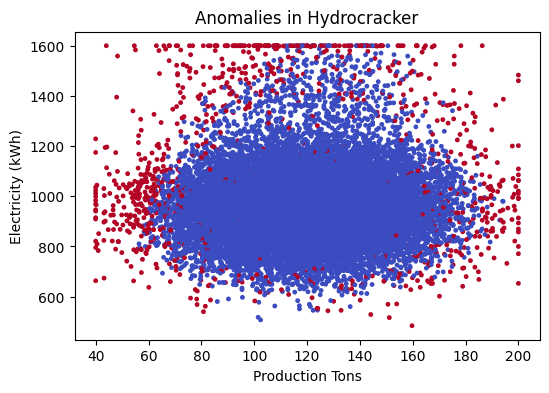

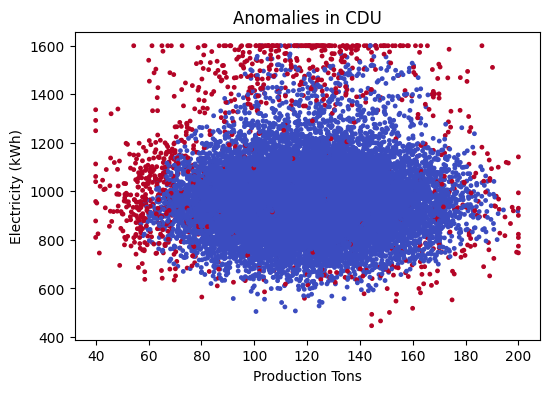

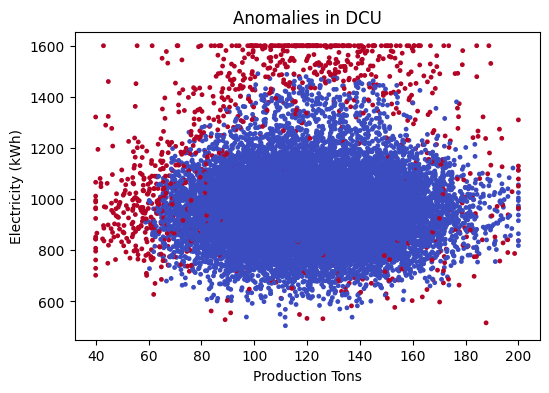

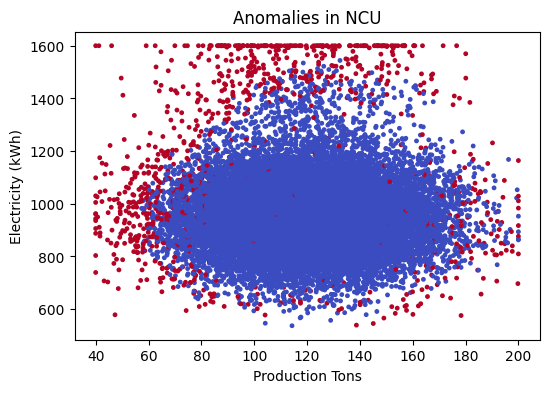

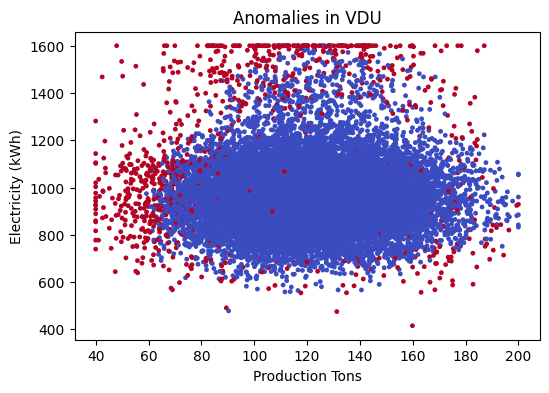

In [16]:
# UNIT-WISE PLOTS
for unit, unit_df in unit_dfs.items():
    plt.figure(figsize=(6,4))
    plt.scatter(
        unit_df["production_tons"],
        unit_df["electricity_kwh"],
        c=unit_df["anomaly"],
        cmap="coolwarm",
        s=6
    )
    plt.title(f"Anomalies in {unit}")
    plt.xlabel("Production Tons")
    plt.ylabel("Electricity (kWh)")
    plt.show()


In [12]:
# SEVERITY CALCULATION
SEC_mean = df["SEC"].mean()

def severity(sec):
    if sec > 1.5 * SEC_mean:
        return "HIGH"
    elif sec > 1.2 * SEC_mean:
        return "MEDIUM"
    else:
        return "LOW"


In [13]:
for unit, unit_df in unit_dfs.items():
    unit_df["severity"] = np.where(
        unit_df["anomaly"] == 1,
        unit_df["SEC"].apply(severity),
        "NORMAL"
    )
    unit_dfs[unit] = unit_df


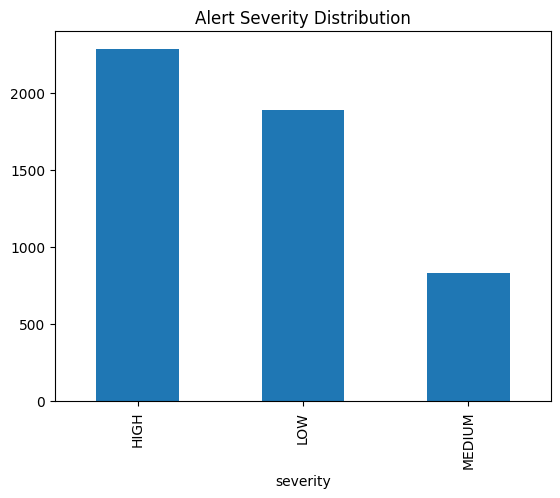

In [14]:
# SEVERITY DISTRIBUTION
alerts_df = pd.concat(unit_dfs.values())
alerts_df = alerts_df[alerts_df["anomaly"] == 1]

alerts_df["severity"].value_counts().plot(
    kind="bar", title="Alert Severity Distribution"
)
plt.show()


SEND AUTOMATED GMAIL ALERT

In [15]:
EMAIL = "dharambaba2k4@gmail.com"
APP_PASSWORD = "fugmkuhfxtzeutjm"

msg = EmailMessage()
msg["Subject"] = " Automated Refinery Energy Anomaly Report"
msg["From"] = EMAIL
msg["To"] = "dharamcodemystery@gmail.com"
msg.set_content("Attached is the automated anomaly alert report.")

with open("refinery_alert_report.csv", "rb") as f:
    msg.add_attachment(
        f.read(),
        maintype="application",
        subtype="octet-stream",
        filename="refinery_alert_report.csv"
    )

with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
    server.login(EMAIL, APP_PASSWORD)
    server.send_message(msg)

print(" Automated alert email sent!")


FileNotFoundError: [Errno 2] No such file or directory: 'refinery_alert_report.csv'